In [2]:
import pickle
import os
import pandas as pd
from glob import glob
from tqdm import tqdm
import geopandas as gpd

In [29]:
road_network = gpd.read_file("/data_nas/GoogleSV/metadata/China/HongKong/edges.shp")
data = pd.read_csv('/data2/cehou/LLM_safety/img_text_data/mapping/export_files/age_30_female/age_30_female.csv')
metadata = pd.read_pickle("/data_nas/GoogleSV/metadata/China/HongKong/download_pano_2024-08-17 13:11:09.125553_23512.p")

In [6]:
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt

# 选择特征
features = data[['lat', 'lon']]

# 创建并拟合 KMeans 模型
kmeans = KMeans(n_clusters=100, random_state=42)
data['cluster'] = kmeans.fit_predict(features)

# # 可视化聚类结果
# plt.figure(figsize=(10, 6))
# plt.scatter(data['lon'], data['lat'], c=data['cluster'], cmap='viridis', marker='.')
# plt.xlabel('Longitude')
# plt.ylabel('Latitude')
# plt.title('KMeans Clustering')
# plt.show()

/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [9]:
data[data['Score'].notna()].value_counts('cluster')

cluster
24    314
39    298
97    253
61    251
30    245
     ... 
68     12
31      9
90      6
93      5
94      4
Length: 100, dtype: int64

In [27]:
import numpy as np
from pykrige.ok import OrdinaryKriging

import pykrige.kriging_tools as kt
sampled_data = data[data['cluster'] == 24]
sampled_data = sampled_data.drop_duplicates(subset=['lat', 'lon'])

# # Extract the coordinates and the Score values
# coords = sampled_data[['lon', 'lat']].values
# scores = sampled_data['Score'].values

# # Mask for missing values
# mask = ~np.isnan(scores)

# # Perform Ordinary Kriging
# OK = OrdinaryKriging(
#     coords[mask, 0], coords[mask, 1], scores[mask],
#     variogram_model='linear',
#     verbose=False,
#     enable_plotting=False
# )

# # Interpolate missing values
# z, ss = OK.execute('points', coords[~mask, 0], coords[~mask, 1])

# # Fill the missing values in the original dataframe
# sampled_data.loc[~mask, 'Score'] = z

In [60]:
from scipy.spatial import cKDTree

k = 10
# 获取已知 Score 的点
known_points = sampled_data[sampled_data['Score'].notna()]
unknown_points = sampled_data[sampled_data['Score'].isna()]

# 构建 KDTree
tree = cKDTree(known_points[['lon', 'lat']])

# 查找每个未知点的最近的五个已知点
distances, indices = tree.query(unknown_points[['lon', 'lat']], k=k)

# 计算反距离权重
weights = 1 / distances
weights /= weights.sum(axis=1)[:, None]

interpolated_score_matrix = np.zeros(indices.shape)
for i in range(indices.shape[0]):
    for j in range(indices.shape[1]):
        interpolated_score_matrix[i, j] = known_points.iloc[indices[i, j]]['Score']

# 计算加权平均值
interpolated_scores = (weights * interpolated_score_matrix).sum(axis=1)

# 将插值结果赋值给未知点
sampled_data.loc[sampled_data['Score'].isna(), 'Score'] = interpolated_scores

<Axes: >

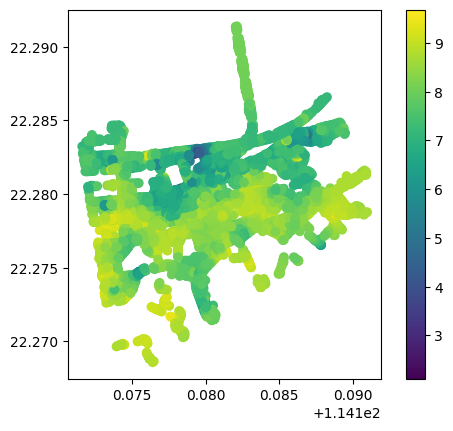

In [61]:
gpd.GeoDataFrame(sampled_data, geometry=gpd.points_from_xy(sampled_data.lon, sampled_data.lat)).plot(column='Score', legend=True)

In [30]:
data = data.merge(metadata[['panoid','id']], on='panoid', how='left')
data.drop_duplicates(subset=['panoid'], inplace=True)
road_network_tidyed = road_network.reset_index().rename({'index':'id'}, axis=1)[['id','geometry']]
data.merge(road_network_tidyed,how='left', on='id')

,panoid,lat,lon,age,gender,location,event,Score,geometry_x,id,geometry_y
0,KtHXnMKIroDc_BK-EePEww,22.310002,114.171100,NaN,NaN,NaN,NaN,NaN,POINT (114.1710998008105 22.31000222373331),10,"LINESTRING (114.17134 22.29472, 114.17149 22.2..."
1,uaWZV0lCAQRN4qCbvBy-uQ,22.310017,114.171079,NaN,NaN,NaN,NaN,NaN,POINT (114.171079209098 22.31001653933256),10,"LINESTRING (114.17134 22.29472, 114.17149 22.2..."
2,z39LXK-I0_FXEzPSFD4QUQ,22.309992,114.171083,NaN,NaN,NaN,NaN,NaN,POINT (114.1710827468813 22.30999222404735),10,"LINESTRING (114.17134 22.29472, 114.17149 22.2..."
3,iN2ZLjRQCcddBoZLzXwRWA,22.309993,114.171079,30.0,female,HongKong,traffic accident,7.723565,POINT (114.1710793905228 22.30999334915613),10,"LINESTRING (114.17134 22.29472, 114.17149 22.2..."
4,ZU_JDaoWqgp1wFT9Z_WB5Q,22.310023,114.171109,NaN,NaN,NaN,NaN,NaN,POINT (114.1711089627616 22.31002291934028),10,"LINESTRING (114.17134 22.29472, 114.17149 22.2..."
...,...,...,...,...,...,...,...,...,...,...,...
472196,Si2I58v1AvzCCd7IV8cbZw,22.434322,114.024528,NaN,NaN,NaN,NaN,NaN,POINT (114.0245282039093 22.43432223464054),23511,"LINESTRING (114.02739 22.45173, 114.02731 22.4..."
472197,_L1riyM1wl9AJpnWw9ZzkA,22.434405,114.024567,NaN,NaN,NaN,NaN,NaN,POINT (114.0245665876067 22.43440517032457),23511,"LINESTRING (114.02739 22.45173, 114.02731 22.4..."
472198,CSQu5c-LqgI4E6WjDCL3hg,22.434491,114.024594,NaN,NaN,NaN,NaN,NaN,POINT (114.0245939008268 22.43449121014432),23511,"LINESTRING (114.02739 22.45173, 114.02731 22.4..."
472199,sQUOwSSIJ83d3IPgr1mKrg,22.434581,114.024615,NaN,NaN,NaN,NaN,NaN,POINT (114.0246145899094 22.43458059243828),23511,"LINESTRING (114.02739 22.45173, 114.02731 22.4..."


In [65]:
notna_data = data[data['Score'].notna()]
non_data = data[data['Score'].isna()]
non_data_sampled = non_data.sample(n=1000, random_state=42)
test_data = pd.concat([notna_data, non_data_sampled])

In [66]:
test_data_gdf = gpd.GeoDataFrame(test_data, geometry=gpd.points_from_xy(test_data['lon'], test_data['lat']))
test_data_gdf.set_crs(epsg=4326, inplace=True)
test_data_gdf.to_crs(epsg=2326, inplace=True)
test_data_gdf['local_x'] = test_data_gdf.geometry.x
test_data_gdf['local_y'] = test_data_gdf.geometry.y

In [67]:
test_data_gdf

,panoid,lat,lon,age,gender,location,event,Score,geometry,local_x,local_y
3,iN2ZLjRQCcddBoZLzXwRWA,22.309993,114.171079,30.0,female,HongKong,traffic accident,7.723565,POINT (835670.909 819002.358),835670.908523,819002.358430
79,IAIICK51mqlM_nqsLMLQjA,22.311837,114.170556,30.0,female,HongKong,traffic accident,9.284649,POINT (835617.005 819206.465),835617.005393,819206.464636
108,fnXaSHNrMUC6OghjSRNeLw,22.314086,114.172097,30.0,female,HongKong,traffic accident,8.986175,POINT (835775.746 819455.601),835775.745500,819455.601083
147,OleYTeYHN2s8AHIq2iEpVA,22.313029,114.170566,30.0,female,HongKong,traffic accident,5.062602,POINT (835618.002 819338.506),835618.001609,819338.506280
178,IOD2Q_a9csU6mDHa1900Gw,22.312574,114.170827,30.0,female,HongKong,traffic accident,9.161703,POINT (835644.927 819288.135),835644.926797,819288.135301
...,...,...,...,...,...,...,...,...,...,...,...
120612,1Ua_tgKqYQuSXOue5i-ubg,22.307786,114.232207,NaN,NaN,NaN,NaN,NaN,POINT (841969.382 818758.936),841969.382369,818758.935569
449926,CyVHLaqhL4HTFuO1SFvcUg,22.295875,113.957012,NaN,NaN,NaN,NaN,NaN,POINT (813611.835 817455.417),813611.835019,817455.416663
184777,yJAvmoAtdkbNHYDSMtFoeg,22.317559,114.187665,NaN,NaN,NaN,NaN,NaN,POINT (837379.789 819840.197),837379.789078,819840.197430
614450,Jw2M-v6zCluyd1NQ7RrdRQ,22.394760,113.976750,NaN,NaN,NaN,NaN,NaN,POINT (815660.353 828402.720),815660.352796,828402.719840
